In [76]:
import os
import math

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from numpy import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

rd_seed = 333

## Načtení dat

In [2]:
path_file = os.sep.join(['data', 'dm_vysledky_studentu_v_predmetech_mv_klasifikace_fact.csv'])
klasifikace_fact = pd.read_csv(path_file, sep=";")

path_file = os.sep.join(['data', 'dm_vysledky_studentu_v_predmetech_mv_student_dim.csv'])
student_dim = pd.read_csv(path_file, sep=";")

path_file = os.sep.join(['created_data', 'studium.csv'])
studium = pd.read_csv(path_file, sep=",")

path_file = os.sep.join(['predmety', 'courses_bak_spec.csv'])
courses_bak_spec = pd.read_csv(path_file, sep=",")

path_file = os.sep.join(['created_data', 'important_courses_matrix.csv'])
important_courses_matrix = pd.read_csv(path_file, sep=",", index_col='studium_id')

path_file = os.sep.join(['created_data', 'successful_students.npy'])
successful_students = load(path_file).astype(int)

path_file = os.sep.join(['created_data', 'failed_students.npy'])
failed_students = load(path_file).astype(int)

In [3]:
important_courses_matrix

,BI-AAG,BI-ZMA,BI-LIN,BI-ZDM,prumer
studium_id,,,,,
17929506,NaN,2.5,3.0,NaN,2.750000
17931206,NaN,NaN,NaN,NaN,NaN
15569706,1.5,1.5,2.0,2.0,1.750000
16729706,4.0,2.0,4.0,NaN,3.333333
17931606,NaN,2.5,NaN,NaN,2.500000
...,...,...,...,...,...
19351806,NaN,NaN,NaN,NaN,NaN
19351406,NaN,NaN,NaN,NaN,NaN
19351006,NaN,NaN,NaN,NaN,NaN


## Vytvoření nového datasetu

In [4]:
studium_sub = studium[['studium_id', 'datum_zahajeni', 'rok_maturity']]

In [5]:
student_sub = student_dim[['studium_id', 'pohlavi_kod', 'statni_prislusnost_nazev']]
student_sub['je_cech'] = 0

for index, row in student_sub.iterrows():
    if row['statni_prislusnost_nazev'] == 'Česko':
        student_sub.loc[index, 'je_cech'] = 1
    else: 
        student_sub.loc[index, 'je_cech'] = 0
        
student_sub = student_sub.drop(columns='statni_prislusnost_nazev')

<ipython-input-5-6bb2cc02109a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_sub['je_cech'] = 0
/home/kapitann/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [6]:
matrix = student_sub.merge(studium_sub, how='outer', on='studium_id')
matrix['dostudoval_uspesne'] = 0

matrix_update = matrix.copy(deep=True)
for index, row in matrix.iterrows():
    if row['studium_id'] in successful_students:
        matrix_update.loc[index, 'dostudoval_uspesne'] = 1
    elif row['studium_id'] not in failed_students:
        matrix_update = matrix_update.drop(labels=index, axis=0)
matrix = matrix_update.copy(deep=True)

In [7]:
ids = matrix['studium_id']
matrix[ids.isin(ids[ids.duplicated()])]

,studium_id,pohlavi_kod,je_cech,datum_zahajeni,rok_maturity,dostudoval_uspesne
3633,6269406,M,1.0,2012,2012,0
3634,6269406,M,1.0,2012,2012,0
3637,12033706,M,1.0,2015,2012,1
3638,12033706,M,1.0,2015,2012,1


In [8]:
matrix = matrix.merge(important_courses_matrix, how='inner', on='studium_id')


In [9]:
matrix.dropna()

,studium_id,pohlavi_kod,je_cech,datum_zahajeni,rok_maturity,dostudoval_uspesne,BI-AAG,BI-ZMA,BI-LIN,BI-ZDM,prumer
1534,12973406,M,1.0,2016,2011,1,2.0,1.5,2.5,2.5,2.125
1620,12964406,M,1.0,2016,2011,0,3.0,3.0,3.0,2.0,2.750
1844,13013306,M,1.0,2016,2012,1,1.0,2.0,2.5,2.5,2.000
2290,11746506,M,1.0,2015,2012,1,2.5,2.5,2.5,2.5,2.500
2517,11737206,Z,1.0,2015,2015,1,3.0,2.5,2.5,2.5,2.625
...,...,...,...,...,...,...,...,...,...,...,...
7232,17323406,M,0.0,2019,2012,0,4.0,2.5,2.5,2.5,2.875
7237,17330906,Z,1.0,2019,2019,0,1.5,2.0,2.0,4.0,2.375
7244,17321106,Z,1.0,2019,2019,0,4.0,2.5,2.5,2.0,2.750
7255,17328906,Z,1.0,2019,2019,0,4.0,3.0,4.0,4.0,3.750


In [10]:
matrix = matrix.fillna(0)

In [11]:
matrix = matrix.drop_duplicates(subset=['studium_id'])
matrix = matrix.set_index('studium_id')
matrix = matrix.replace('M', 0)
matrix = matrix.replace('Z', 1)

In [12]:
matrix.mean()

pohlavi_kod              0.111427
je_cech                  0.806393
datum_zahajeni        2014.293904
rok_maturity          1997.130063
dostudoval_uspesne       0.271257
BI-AAG                   0.400867
BI-ZMA                   0.695548
BI-LIN                   0.481688
BI-ZDM                   0.347353
prumer                   0.836779
dtype: float64

In [13]:
matrix[matrix['dostudoval_uspesne'] == 0]

,pohlavi_kod,je_cech,datum_zahajeni,rok_maturity,dostudoval_uspesne,BI-AAG,BI-ZMA,BI-LIN,BI-ZDM,prumer
studium_id,,,,,,,,,,
1584806,0,0.0,2009,2006,0,0.0,0.0,0.0,0.0,0.0
4783406,0,1.0,2011,2009,0,0.0,0.0,0.0,0.0,0.0
8396706,1,1.0,2013,2009,0,0.0,0.0,0.0,0.0,0.0
4288906,0,1.0,2010,0,0,0.0,0.0,0.0,0.0,0.0
5497506,1,1.0,2011,2009,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1754106,0,0.0,2009,2007,0,0.0,0.0,0.0,0.0,0.0
2815106,0,1.0,2009,2009,0,0.0,0.0,0.0,0.0,0.0
6280106,0,1.0,2012,2008,0,0.0,0.0,0.0,0.0,0.0


In [14]:
matrix[matrix['dostudoval_uspesne'] == 1]

,pohlavi_kod,je_cech,datum_zahajeni,rok_maturity,dostudoval_uspesne,BI-AAG,BI-ZMA,BI-LIN,BI-ZDM,prumer
studium_id,,,,,,,,,,
1578106,0,0.0,2009,2007,1,0.0,0.0,0.0,0.0,0.00
4047706,0,1.0,2010,2009,1,0.0,0.0,0.0,0.0,0.00
12375406,0,1.0,2015,2009,1,3.0,2.5,0.0,0.0,2.75
1565606,0,1.0,2009,2009,1,0.0,0.0,0.0,0.0,0.00
1565706,0,1.0,2009,2009,1,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
1755006,0,1.0,2009,0,1,0.0,0.0,0.0,0.0,0.00
4220606,0,1.0,2010,0,1,0.0,0.0,0.0,0.0,0.00
4224106,0,1.0,2010,0,1,0.0,0.0,0.0,0.0,0.00


In [30]:
matrix[matrix['prumer'] == 0]

,pohlavi_kod,je_cech,datum_zahajeni,rok_maturity,dostudoval_uspesne,BI-AAG,BI-ZMA,BI-LIN,BI-ZDM,prumer
studium_id,,,,,,,,,,
1578106,0,0.0,2009,2007,1,0.0,0.0,0.0,0.0,0.0
1584806,0,0.0,2009,2006,0,0.0,0.0,0.0,0.0,0.0
4783406,0,1.0,2011,2009,0,0.0,0.0,0.0,0.0,0.0
8396706,1,1.0,2013,2009,0,0.0,0.0,0.0,0.0,0.0
4047706,0,1.0,2010,2009,1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2815106,0,1.0,2009,2009,0,0.0,0.0,0.0,0.0,0.0
6280106,0,1.0,2012,2008,0,0.0,0.0,0.0,0.0,0.0
3727706,0,1.0,2010,2009,1,0.0,0.0,0.0,0.0,0.0


In [48]:
matrix[(matrix['prumer'] == 0) & (matrix['dostudoval_uspesne'] == 0)]

,pohlavi_kod,je_cech,datum_zahajeni,rok_maturity,dostudoval_uspesne,BI-AAG,BI-ZMA,BI-LIN,BI-ZDM,prumer
studium_id,,,,,,,,,,
1584806,0,0.0,2009,2006,0,0.0,0.0,0.0,0.0,0.0
4783406,0,1.0,2011,2009,0,0.0,0.0,0.0,0.0,0.0
8396706,1,1.0,2013,2009,0,0.0,0.0,0.0,0.0,0.0
4288906,0,1.0,2010,0,0,0.0,0.0,0.0,0.0,0.0
5497506,1,1.0,2011,2009,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1754106,0,0.0,2009,2007,0,0.0,0.0,0.0,0.0,0.0
2815106,0,1.0,2009,2009,0,0.0,0.0,0.0,0.0,0.0
6280106,0,1.0,2012,2008,0,0.0,0.0,0.0,0.0,0.0


In [47]:
matrix[(matrix['prumer'] != 0) & (matrix['dostudoval_uspesne'] == 0)]

,pohlavi_kod,je_cech,datum_zahajeni,rok_maturity,dostudoval_uspesne,BI-AAG,BI-ZMA,BI-LIN,BI-ZDM,prumer
studium_id,,,,,,,,,,
12987806,0,1.0,2016,2010,0,0.0,3.0,4.0,3.0,3.333333
11743906,0,1.0,2015,2010,0,0.0,4.0,0.0,0.0,4.000000
12987706,0,1.0,2016,2010,0,4.0,0.0,0.0,0.0,4.000000
11678106,0,1.0,2015,2010,0,3.0,0.0,0.0,0.0,3.000000
11736306,0,1.0,2015,2011,0,0.0,0.0,0.0,4.0,4.000000
...,...,...,...,...,...,...,...,...,...,...
18597406,1,1.0,2020,2015,0,0.0,4.0,0.0,0.0,4.000000
18596206,0,1.0,2020,2018,0,0.0,4.0,0.0,0.0,4.000000
18588406,0,0.0,2020,2019,0,0.0,2.5,0.0,0.0,2.500000


In [18]:
matrix[(matrix['dostudoval_uspesne'] == 1)]['datum_zahajeni'].mean()

2013.3998091603053

In [54]:
matrix_up = matrix[matrix['prumer'] != 0]

In [55]:
matrix_up

,pohlavi_kod,je_cech,datum_zahajeni,rok_maturity,dostudoval_uspesne,BI-AAG,BI-ZMA,BI-LIN,BI-ZDM,prumer
studium_id,,,,,,,,,,
12375406,0,1.0,2015,2009,1,3.0,2.5,0.0,0.0,2.750000
12967806,0,1.0,2016,2010,1,0.0,3.0,0.0,2.0,2.500000
11719706,0,1.0,2015,2010,1,0.0,2.0,0.0,2.5,2.250000
12987806,0,1.0,2016,2010,0,0.0,3.0,4.0,3.0,3.333333
11743906,0,1.0,2015,2010,0,0.0,4.0,0.0,0.0,4.000000
...,...,...,...,...,...,...,...,...,...,...
18597406,1,1.0,2020,2015,0,0.0,4.0,0.0,0.0,4.000000
18596206,0,1.0,2020,2018,0,0.0,4.0,0.0,0.0,4.000000
18588406,0,0.0,2020,2019,0,0.0,2.5,0.0,0.0,2.500000


## Modelování

In [56]:
Xdata = matrix_up.drop(columns='dostudoval_uspesne')
ydata = matrix_up.dostudoval_uspesne

In [71]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
print("původní data")
#display(Xdata.shape)
display(ydata.shape)
print("trénovací data")
#display(Xtrain.shape)
display(ytrain.shape)
print("testovací data")
#display(Xtest.shape)
display(ytest.shape)

původní data


(2190,)

trénovací data


(1642,)

testovací data


(548,)

In [58]:
ytest.mean()

0.35583941605839414

In [69]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=5)

In [70]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (train): 0.956760
accuracy score (test): 0.948905


[Text(167.4, 190.26, 'X[7] <= 0.5\ngini = 0.392\nsamples = 5795\nvalue = [4243, 1552]'),
 Text(83.7, 135.9, 'X[2] <= 2014.5\ngini = 0.317\nsamples = 4995\nvalue = [4010, 985]'),
 Text(41.85, 81.53999999999999, 'X[2] <= 2011.5\ngini = 0.434\nsamples = 2956\nvalue = [2016, 940]'),
 Text(20.925, 27.180000000000007, 'gini = 0.463\nsamples = 1354\nvalue = [861, 493]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.402\nsamples = 1602\nvalue = [1155, 447]'),
 Text(125.55000000000001, 81.53999999999999, 'X[3] <= 2013.5\ngini = 0.043\nsamples = 2039\nvalue = [1994, 45]'),
 Text(104.625, 27.180000000000007, 'gini = 0.257\nsamples = 185\nvalue = [157, 28]'),
 Text(146.475, 27.180000000000007, 'gini = 0.018\nsamples = 1854\nvalue = [1837, 17]'),
 Text(251.10000000000002, 135.9, 'X[8] <= 2.792\ngini = 0.413\nsamples = 800\nvalue = [233, 567]'),
 Text(209.25, 81.53999999999999, 'X[8] <= 2.562\ngini = 0.206\nsamples = 625\nvalue = [73, 552]'),
 Text(188.32500000000002, 27.180000000000007, 

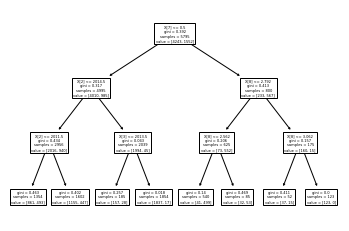

In [24]:
tree.plot_tree(dt)

In [72]:
ypredicted = dt.predict(Xtrain)

In [73]:
ypredicted

array([0, 1, 1, ..., 0, 0, 1])

In [74]:
for y in ypredicted:
    print(y)

0
1
1
0
1
0
0
0
0
0
0
0
1
0
1
0
1
0
1
1
1
1
0
0
0
1
0
1
1
0
1
0
0
0
0
0
0
0
0
1
0
1
0
0
0
1
0
0
0
0
1
0
1
0
0
1
0
1
1
0
1
0
0
0
0
1
0
1
1
0
1
0
1
1
1
0
1
0
0
0
1
0
1
0
0
0
0
0
1
0
1
0
0
0
1
0
0
0
1
0
0
1
0
1
0
0
0
1
0
0
0
0
0
0
1
1
1
0
1
0
0
0
0
1
1
1
0
0
1
0
1
0
0
0
1
0
0
0
1
0
1
0
1
1
0
0
0
0
0
0
0
0
1
1
0
1
0
1
0
0
0
0
0
0
1
1
1
1
0
0
0
0
1
0
1
1
1
0
1
0
1
0
0
0
0
1
1
1
0
0
0
0
1
0
0
1
0
0
1
0
1
0
0
0
0
0
0
1
1
0
0
1
0
1
1
0
0
0
0
1
0
0
1
1
1
0
1
0
1
0
0
0
0
0
0
1
1
0
0
0
1
0
1
1
1
1
1
1
0
0
1
0
0
1
0
1
0
0
0
0
1
1
1
0
0
0
1
0
0
1
0
0
1
0
1
0
0
1
0
0
1
1
0
0
0
0
1
1
0
1
1
0
0
0
0
1
0
1
1
0
1
1
0
1
1
1
0
1
0
1
0
0
0
0
1
1
1
0
1
1
0
1
0
0
0
0
1
1
0
0
0
1
1
0
1
0
0
0
0
0
1
0
0
1
1
1
0
0
0
0
1
0
0
0
0
0
1
0
1
1
0
0
1
0
0
0
0
0
1
0
0
0
1
1
0
0
0
0
1
0
0
0
0
0
1
1
0
0
1
1
1
1
0
1
0
0
0
0
1
0
1
0
0
1
0
1
0
0
1
1
0
1
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
1
1
0
1
0
1
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
1
0
1
0
0
1
1
1
1
0
1
0
0
1
0
0
1
1
1
0
1
0
0
1
1
0
1
0
1
0
0
0
0
1
0
1
1
0
1
0
1
1
1


In [77]:
Xtest

,pohlavi_kod,je_cech,datum_zahajeni,rok_maturity,BI-AAG,BI-ZMA,BI-LIN,BI-ZDM,prumer
studium_id,,,,,,,,,
15549306,0,1.0,2018,2015,4.0,2.0,4.0,4.0,3.500000
11701906,1,0.0,2015,2013,0.0,2.5,4.0,0.0,3.250000
12991806,0,0.0,2016,2015,1.0,2.0,1.0,2.0,1.500000
14257106,0,1.0,2017,2017,1.5,2.0,2.5,2.5,2.125000
14283006,0,1.0,2017,2015,3.0,0.0,2.5,2.5,2.666667
14272306,0,1.0,2017,2017,4.0,2.0,2.5,0.0,2.833333
11696406,1,0.0,2015,2010,0.0,1.0,0.0,0.0,1.000000
16187206,0,1.0,2018,2018,0.0,4.0,0.0,0.0,4.000000
13008306,0,1.0,2016,2015,4.0,2.0,2.0,2.5,2.625000


In [78]:
for y in ytest:
    print(y)

0
0
1
1
0
0
0
0
0
1
0
0
1
0
0
0
0
1
0
0
1
1
0
0
1
0
0
1
1
1
0
0
1
1
1
0
1
0
1
0
1
1
0
1
0
0
0
1
0
0
0
0
1
1
0
0
0
1
0
0
0
0
1
0
0
0
0
0
1
1
0
1
0
1
0
0
0
0
0
0
0
1
1
1
0
0
0
1
0
0
0
1
1
0
0
0
1
0
0
0
1
0
0
1
1
0
1
0
1
1
0
0
0
1
1
0
1
0
0
0
1
1
0
0
1
1
0
0
0
0
0
0
1
0
1
0
0
0
1
0
0
0
1
1
1
0
0
1
1
1
1
0
1
1
1
0
1
0
0
0
0
0
1
1
1
1
0
0
1
1
0
0
0
0
1
1
0
0
1
1
0
0
1
0
0
0
0
0
1
0
0
1
0
0
1
0
1
0
1
1
0
0
0
0
0
0
1
1
0
1
0
1
0
1
0
1
1
0
1
0
0
1
1
0
0
1
1
0
1
0
0
1
0
0
0
0
0
0
0
1
1
0
1
1
1
0
1
0
1
0
0
0
0
0
0
0
0
0
1
0
1
0
0
1
1
1
1
0
0
1
1
1
0
0
0
1
0
0
0
0
0
0
1
0
1
1
0
0
0
0
0
0
1
1
1
0
1
0
0
1
0
0
0
0
0
0
1
1
0
1
0
0
0
0
1
0
0
0
1
1
0
1
1
0
0
0
0
0
0
1
0
1
0
1
0
0
1
1
0
1
0
0
0
1
0
1
0
0
0
0
0
0
0
1
0
1
0
0
0
1
0
0
0
1
0
1
1
0
1
1
0
0
1
0
0
1
0
1
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
1
0
1
0
0
0
0
0
1
0
0
0
0
0
1
1
0
0
0
1
0
1
0
1
0
0
0
0
0
0
1
1
0
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
1
0
1
0
1
0
1
1
0
0
0
0
0
1
0
1
0
1
0
0
